# Spectral Mapping


P. Lewis 

UCL/NCEO

31st May 2016

## A5.1 Introduction

Various tools we use aim to provide an optimal estimate of the parameters of a linear model (and their uncertainty) that allow estimation of albedo are related reflectance terms at over set of spectral basis functions. In the original GlobAlbedo work, we defined three broad waveband responses for albedo, being Visible, Near Infrared , and total shortwave. In this section, we demonstrate how this can be extended to other spectral bases.

The algorithm requires that datasets from the set of heterogeneous sensors are mapped to a common spectral basis. This is permissible because we are using linear models throughout, i.e. for spectral and angular modelling. In this section, we derive an initial estimate of appropriate spectral mapping functions using a spectral database provided by DLR.

This involves:

1. Applying bandpass functions to the spectra to simulate spectra for particular sensors
2. Learning mapping functions from a training dataset to allow us to use linear functions to go from one set of sensor bands to another 


## A5.2 The database spectra

The spectral database used here is the same as that used in a previous ESA ADAM study.

This is intended to provide a proof of concept of the approach, and will ideally be replaced by a wider dataset at a later point.

We can examine the types of data contained in the database:

In [3]:
import scipy.io
import pylab as plt
import numpy as np

# read the vegetation spectra from DLR database
spectra_fn = 'dump/spectra/Spectres.sav'
spectra = scipy.io.readsav(spectra_fn)
swl = spectra.wl
spect = spectra.spectres
types = spectra.type

print types

['a1' 'brachypodium x' 'dry vegetation' 'genista retamoides/umbellata (?)'
 'genista umbellata (?)' 'genista umbellata (?)Description'
 'opuntia ficus-indica (dead black part)'
 'opuntia ficus-indica (dead part)'
 'opuntia ficus-indica (dead white part)'
 'opuntia ficus-indica (green part/ vertical)'
 'opuntia ficus-indica (greener part)' 'opuntia ficus-indica (vertical)'
 'palmite humilis' 'palmite humilis (green part)' 'palmite humilis (tronc)'
 'periploca laevigata' 'phlomis lichnytis (?)' 'plant'
 'rhamnus yclodes (?)' 'stipa tenacissius' 'stipa tenacissius (dead part)'
 'thymus hyemalis' 'ulex parviflorus' 'black lichen (on rock)'
 'black lichen on soil' 'black soil lichen' 'black soil lichen crust. soil'
 'green lichen (right same rock surface as 11a)' 'green lichen on rock'
 'green lichen on rockDescription'
 'green lichen on rockDescriptionDescription'
 'grey lichen (middle same rock surface as 11a)' 'grey lichen on stone'
 'mix orange/white lichen&rock surf' 'orange lichen (le

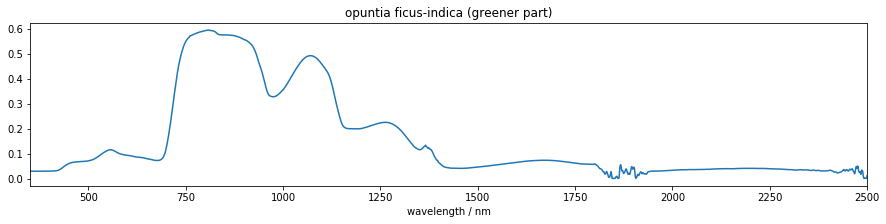

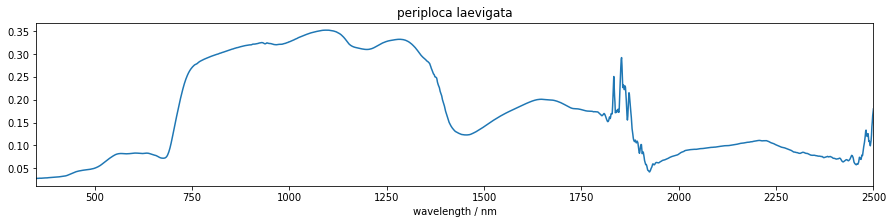

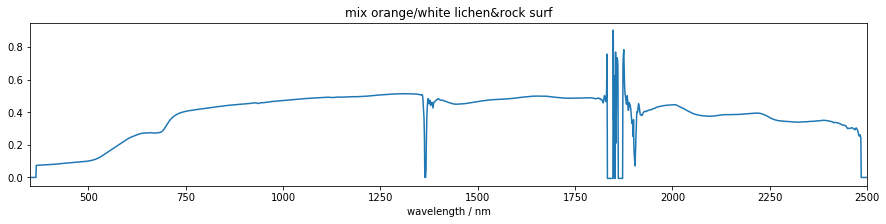

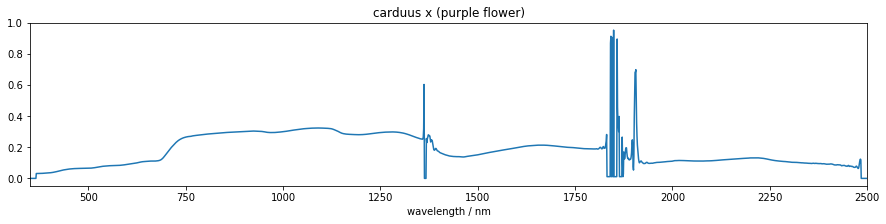

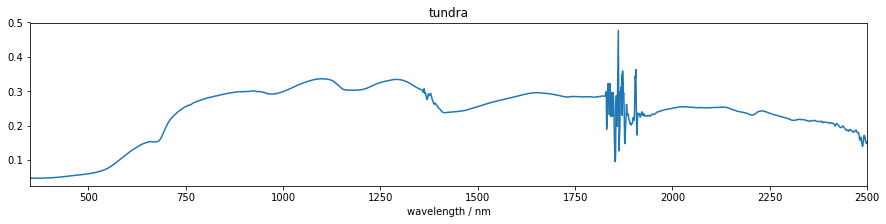

In [4]:
for i in [10,15,33,45,-18]:
    plt.figure(figsize=(15,3))
    plt.plot(swl,spect[i])
    plt.xlim(swl[0],swl[-1])
    plt.xlabel('wavelength / nm')
    plt.title(types[i])
    plt.show()

## A5.3 Applying bandpass functions to the database spectra.

We develop an integration function that takes two dictionaries where the first holds a spectrum, e.g. of vegetation, and the other holds the bandpass

In [5]:
import numpy as np
from scipy.interpolate import interp1d
import scipy, scipy.io
import matplotlib.pyplot as plt
import os, glob, pickle

import numpy as np
import scipy
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import datetime

import pickle
%matplotlib inline

In [6]:
def integrate(spectrum, bandpass, minimum, maximum, dlambda):
    r = interp1d(spectrum['wavelength'], spectrum['reflectance'], bounds_error=False, fill_value=0)
    b = interp1d(bandpass['wavelength'], bandpass['rsr'], bounds_error=False, fill_value=0)
    
    d = np.arange(minimum, maximum, dlambda)
    integral = np.sum(r(d) * b(d) * dlambda)
    bsum = np.sum(b(d) * dlambda)
    norm = integral / bsum
    return norm

We will make a dictionary that holds for every sensor (i.e. MERIS, Terra, Aqua, Sentinel 2) an array of m x n where m is the number of vegetation spectra (from DLR) and n is the number of wavebands associated with the sensor. Each element of this array holds the vegetation reflectance integrated over the bandpass, i.e., the relative spectral response curve. In addition, for each sensor we also create a list of centre wavelengths corresponding to the array columns.

In [7]:
# read the bandpasses
bandpass_fn = 'dump/rsr/rsr.dump'
bandpass_f = open(bandpass_fn, 'r')
rsr = pickle.load(bandpass_f)
bandpass_f.close()

# prepare a dictionary holding arrays of m x n (no. of spectra x no. of bands) for each sensor
integrated_spectra = {}

m = np.shape(spect)[0]
n_meris = len(rsr['meris']['c1'].keys())
n_terra = len(rsr['terra']['c1'].keys())
n_aqua = len(rsr['aqua']['c1'].keys())
n_sentinel2 = len(rsr['sentinel2']['c1'].keys())
n_vgt = len(rsr['vgt']['c1'].keys())

integrated_spectra['meris'] = np.zeros((m, n_meris), dtype=float)
integrated_spectra['terra'] = np.zeros((m, n_terra), dtype=float)
integrated_spectra['aqua'] = np.zeros((m, n_aqua), dtype=float)
integrated_spectra['sentinel2'] = np.zeros((m, n_sentinel2), dtype=float)
integrated_spectra['vgt'] = np.zeros((m, n_vgt), dtype=float)

# populate the dictionary with vegetation spectra integrated over the sensor bandpasses
c = 'c1' # fix the camera/channel
for sensor in ['meris', 'terra', 'aqua', 'sentinel2', 'vgt']:
    bands = rsr[sensor][c].keys()
    # create a new/empty array and centre wavelength list
    integrefl = np.zeros((m, len(bands)), dtype=float)
    cwls = []
    for band in range(1, len(bands)+1 ):
        wl = rsr[sensor][c]['band%s' % band]['wavelength']
        relresp = rsr[sensor][c]['band%s' % band]['rsr']
        cwls.append( rsr[sensor][c]['band%s' % band]['cwl'] )
        bandpass = {'wavelength': wl, 'rsr': relresp}
        for i in range(m):
            refl = spect[i, :]
            spectrum = {'wavelength': swl, 'reflectance': refl}
            integrefl[i,band-1] = integrate(spectrum, bandpass, 300, 2500, 1.0)
    
    cwls = np.asarray(cwls)
    integrated_spectra[sensor] = {'integrefl': integrefl, 'cwls': cwls}

And we visualize the results...

[  646.2956733    856.47984028   465.7423988    553.73622982  1242.16286011
  1629.40788053  2114.21403827]


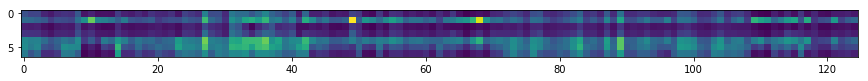

In [8]:
sensor = 'terra'
plt.figure(figsize=(15,3))
plt.imshow( integrated_spectra[sensor]['integrefl'].T, interpolation='none' )
print integrated_spectra[sensor]['cwls']
plt.show()

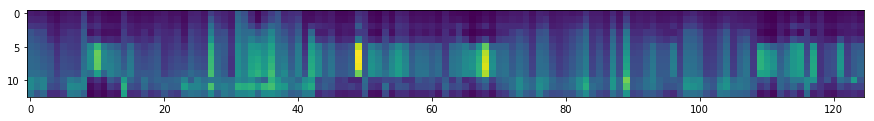

In [9]:
sensor = 'sentinel2'
# plot in order of band numbers, not necessarily in order of their centre wavelengths...
plt.figure(figsize=(15,3))
plt.imshow(integrated_spectra[sensor]beta_hat['integrefl'].T, interpolation='none')
plt.show()

For one sensor, plot the integrated reflectance (i.e. vegetation spectrum integrated over the sensor bandpasses).

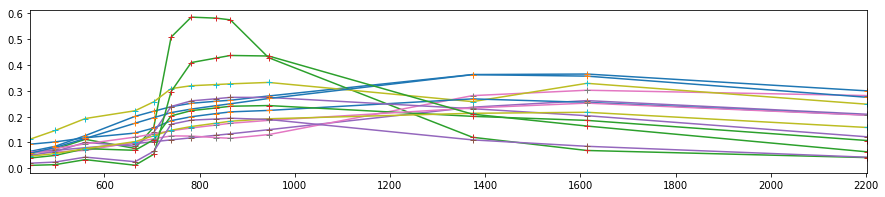

In [10]:
sensor = 'sentinel2'
plt.figure(figsize=(15,3))
for i in range(0, m, 10): # pick some vegetation spectra
    # sort the second dimenions of our integrefl array w.r.t. cwls
    cwls = integrated_spectra[sensor]['cwls']
    e = np.argsort(cwls)
    integrefl = integrated_spectra[sensor]['integrefl'][i,:]
    plt.plot( cwls[e], integrefl[e])
    plt.plot( cwls[e], integrefl[e], '+' )
plt.xlim(cwls[e][0],cwls[e][-1])
plt.show()

For one specific vegetation spectrum, plot the reflectance integrated over the sensor bandpasses for all sensor-band combinations.

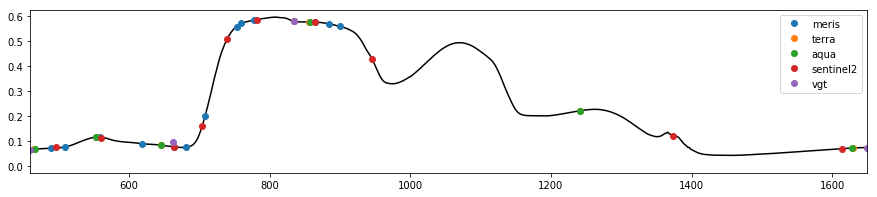

In [11]:
spect_no = 10
plt.figure(figsize=(15,3))
plt.plot(swl, spect[spect_no,:], 'k-')

for sensor in ['meris', 'terra', 'aqua', 'sentinel2', 'vgt']:
    # do some sorting of the second dimension of our integrefl array
    cwls = integrated_spectra[sensor]['cwls']
    e = np.argsort(cwls)
    integrefl = integrated_spectra[sensor]['integrefl'][spect_no,:]
    cwls = cwls[e]
    integrefl = integrefl[e]    
    plt.plot(cwls, integrefl, 'o', label=sensor)
plt.xlim(cwls[e][0],cwls[e][-1])
plt.legend()
plt.show()

In [13]:
# save
fl = open('dump/integrated_spectra/integrated_spectra.dump', 'w')
pickle.dump(integrated_spectra, fl)
fl.close()

## A5.4 Finding linear mappings for the different sensors

In this section, we develop the set of linear mapping functions.

These are texsted with a subset of the data (27 samples), with the resul used for training.

In [14]:
def fit(X, y):
    # solve normal equations
    beta_hat = (X.T * X).I * X.T * y
    
    # estimate y given X
    y_hat = X * beta_hat
    
    # compute the variance of y given X, var(y|X) = var(epsilon|X)
    e = y - y_hat
    var_y_given_X = np.std(e)**2 # this value is the sum (product?) of the
    # conditional variance and the variance that results from not knowing
    # the true values of beta
    return beta_hat, var_y_given_X

def evaluate(Xnew, X, beta_hat, var_y_given_X):
    # evaluate the model at values in Xnew
    y_pred = Xnew * beta_hat
    
    # compute variance of 
    u = var_y_given_X * (1.0 + Xnew * (X.T * X).I * Xnew.T)
    var_pred = np.diag(u)
    
    return y_pred, var_pred

# copied from: http://adorio-research.org/wordpress/?p=1932
def AIC(RSS, k, n):
    """
    Computes the Akaike Information Criterion.
 
       RSS-residual sum of squares of the fitting errors.
       k  - number of fitted parameters.
       n  - number of observations.
    """
    AIC = 2 * k + n * (np.log(2 * np.pi * RSS/n) + 1)
    return AIC

In [16]:
fn = 'dump/integrated_spectra/integrated_spectra.dump'
fl = open(fn, 'r')
integrated_spectra = pickle.load(fl)
fl.close()

In [17]:
# Create sets of test and training data
test_size = 27

n = 125 # number of observations or spectra in the DLR database
training_size = n - test_size
spectrum_numbers = np.arange(n)
training_idxs = np.sort( np.random.choice(n, size=training_size, replace=False ) ).astype(int)
test_idxs = np.delete(spectrum_numbers, training_idxs)

print 'training', training_idxs
print ''
print 'testing', test_idxs

training [  0   1   3   5   6   7   8   9  13  16  18  19  20  21  22  23  24  25
  26  28  29  30  31  32  33  34  36  37  39  40  41  42  43  45  46  47
  48  49  51  52  53  54  55  56  57  59  60  61  62  63  64  65  66  67
  68  69  70  71  72  74  75  76  77  78  80  81  83  84  85  86  89  90
  91  92  93  94  95  96  97  98  99 100 103 104 105 108 109 110 113 114
 115 116 117 119 120 121 122 124]

testing [  2   4  10  11  12  14  15  17  27  35  38  44  50  58  73  79  82  87
  88 101 102 106 107 111 112 118 123]


In [31]:
# for a given sensor A
# ... for a given band
# ... ... for another given sensor B
# ... ... ... compute distance (wavelength) between bands of B to the selected band of A
# ... ... ... build linear models that map bands of B to the band of A, always include bands nearer to the selected band of A
# ... ... ... compute an information criterion, e.g. Akaike's index
# ... ... ... store everything in a dictionary format

mappings = {}

sensors = ['terra', 'aqua', 'meris', 'sentinel2', 'vgt']
for sensorA in sensors:
    print sensorA
    
    cwlsA = integrated_spectra[sensorA]['cwls']
    mappings[sensorA] = {}
    
    for bandA, cwlA in enumerate(cwlsA):
        # get observations y that we want to map to
        integreflA = integrated_spectra[sensorA]['integrefl']
        y = np.matrix( integreflA[training_idxs,:][:,bandA] ).T
        mappings[sensorA][bandA] = {}

        for sensorB in sensors:
            if sensorA == sensorB:
                continue
            
            mappings[sensorA][bandA][sensorB] = {}
            
            # compute distance between band of sensorA and bands of sensorB
            cwlsB = integrated_spectra[sensorB]['cwls']
            dist = cwlsB - cwlA
            e = np.argsort(dist)
            
            # build design matrices X with band observation of sensorB
            integreflB = integrated_spectra[sensorB]['integrefl']
            aic_previous = np.inf
            for i in range(1, len(e)+1): # test the first five bands
                bandsB = e[0:i]
                k = len(bandsB) # number of fitted parameters
                assert np.shape(integreflB)[0] == np.shape(integreflA)[0]
                X_ = integreflB[training_idxs,:][:,bandsB] # of shape number of training samples x number of bands considered in linear regression
                
                X = np.matrix( np.hstack(( np.ones(training_size).reshape((training_size, 1)), X_ )) )
                # should we apply some weighting? and how?
                beta_hat, var_y_given_X = fit(X, y)
                y_pred, var_pred = evaluate(X, X, beta_hat, var_y_given_X)
                RSS = (y_pred - y).T * (y_pred - y)
                aic = float(AIC(RSS, k, n))
                
                if aic < aic_previous:
                    mappings[sensorA][bandA][sensorB] = {'bandsB':bandsB, 'cwls':cwlsB[bandsB], \
                                                   'beta_hat':beta_hat, 'AIC':aic, 'var_y_given_X': var_y_given_X}
                    aic_previous = aic

fl = open('mappings.dump', 'w')
pickle.dump(mappings, fl)
fl.close()

terra
aqua
meris
sentinel2
vgt


Part of the quality assurance here is that the test samples should mostly lie within the confidence interval.

In [21]:
sensorA = 'sentinel2'
bandA = 9
sensorB = 'vgt'

cwlA = integrated_spectra[sensorA]['cwls'][bandA]
y = integrated_spectra[sensorA]['integrefl'][:,bandA]

integreflB = integrated_spectra[sensorB]['integrefl']
bandsB = mappings[sensorA][bandA][sensorB]['bandsB']
var_y_given_X = mappings[sensorA][bandA][sensorB]['var_y_given_X']
beta_hat = mappings[sensorA][bandA][sensorB]['beta_hat']

X_ = integreflB[:, bandsB]
X = np.matrix( np.hstack(( np.ones( np.shape(X_)[0] ).reshape(( np.shape(X_)[0], 1)), X_ )) ) # create design matrix

y_pred, var_y = evaluate(X, X, beta_hat, var_y_given_X)

c = 0
for i in test_idxs:
    yp = float(y_pred[i,0])
    sigma = np.sqrt(float(var_y[i]))
    t = 1.96
    bln = (y[i] > (yp - (t * sigma))) and (y[i] < (yp + (t * sigma)))
    #print i, y[i], yp - yvar, yp + yvar, bln
    if bln:
        c+=1

print 'There were', c, 'positives out of', test_size, 'or %.2f' % (float(c)/float(test_size)*100.0), \
                    '% of observations fell within confidence interval'

There were 25 positives out of 27 or 92.59 % of observations fell within confidence interval


Here, we provide examples of the mapping from Sentinel-2 bands to MODIS:

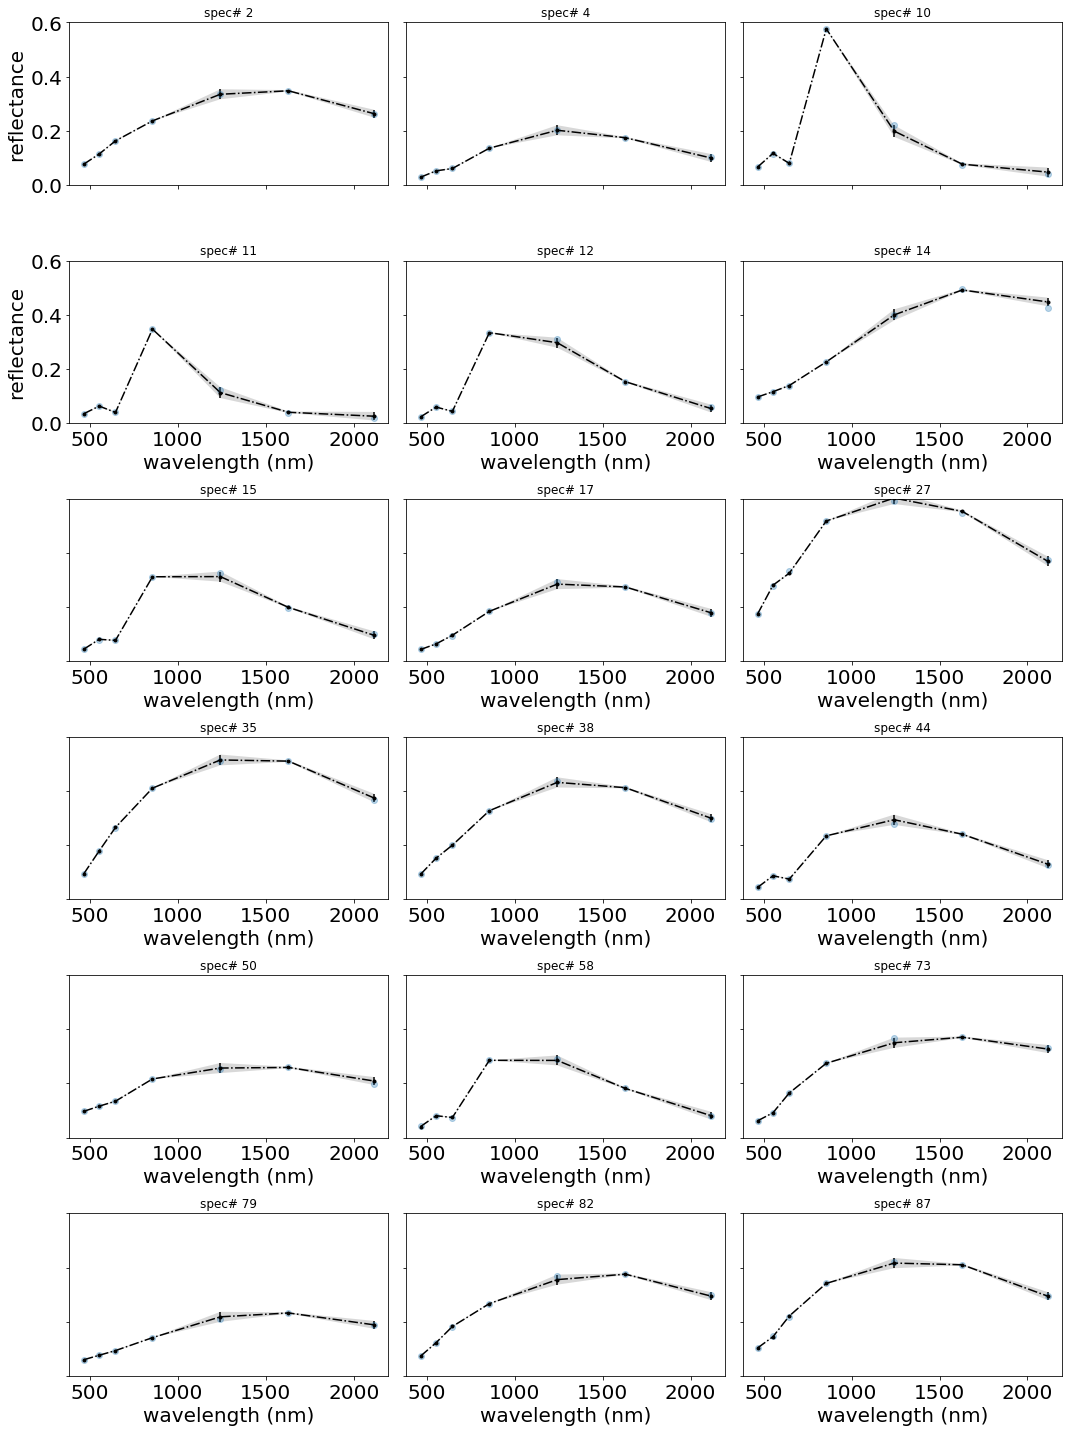

In [22]:
# define here sensorA and sensorB
# sensorA is the one to map to using band observations from sensorB
sensorA = 'terra'
sensorB = 'sentinel2'

# for 27 randomly selected spectra from the DLR database...
nrows = 6 # for image display
ncols = 3 # for image display
fig = plt.figure( figsize = (15, 20))
num_subplots = nrows * ncols

for i, spectrum_number in enumerate(test_idxs[:num_subplots]):
    cwlsA = integrated_spectra[sensorA]['cwls']
    m = len(cwlsA) # m number of bands in sensorA
    bandsA = range(m)
    spectrum = np.zeros((m, 4), dtype=float)
    for bandA in bandsA:
        cwlA = integrated_spectra[sensorA]['cwls'][bandA]
        y = integrated_spectra[sensorA]['integrefl'][:,bandA]

        integreflB = integrated_spectra[sensorB]['integrefl']
        bandsB = mappings[sensorA][bandA][sensorB]['bandsB']
        var_y_given_X = mappings[sensorA][bandA][sensorB]['var_y_given_X']
        beta_hat = mappings[sensorA][bandA][sensorB]['beta_hat']

        X_ = integreflB[:, bandsB]
        X = np.matrix( np.hstack(( np.ones( np.shape(X_)[0] ).reshape(( np.shape(X_)[0], 1)), X_ )) ) # create design matrix

        y_pred, var_y = evaluate(X, X, beta_hat, var_y_given_X)

        yp = float(y_pred[spectrum_number,0]) # y_pred is a column vector, we still index in full 2 dimensions...
        sigma = np.sqrt(float(var_y[spectrum_number]))
        t = 1.96
        y_lower = yp - (t * sigma)
        y_upper = yp + (t * sigma)

        spectrum[bandA, :] = y_lower, yp, y_upper, sigma
    
    # plot in order of centre wavelengths
    e = np.argsort(cwlsA)
    ax = fig.add_subplot(nrows, ncols, i+1)

    ax.set_ylim((0, 0.6))
    ax.locator_params(axis='y',nbins=4)
    if i+1 > 3:
        for tick in ax.xaxis.get_major_ticks():
            tick.label.set_fontsize(20)
        ax.set_xlabel("wavelength (nm)", fontsize=20)
    else:
        ax.set_xticklabels( () )

    
    if i+1 == 1 or i+1 == 4:
        for tick in ax.yaxis.get_major_ticks():
                tick.label.set_fontsize(20)
        ax.set_ylabel("reflectance", fontsize=20)
    else:
        ax.set_yticklabels(())
    
    plt.plot(cwlsA[e], integrated_spectra[sensorA]['integrefl'][spectrum_number, e], 'o', alpha=0.3)
    plt.errorbar(cwlsA[e], spectrum[e,1], yerr=1.96*spectrum[e,3], fmt='.', color='black')
    # in case you may want to interpolate between bands...
    plt.plot(cwlsA[e], spectrum[e,1], 'k-.')
    plt.fill_between(cwlsA[e], spectrum[e,0], spectrum[e,2], facecolor='grey', alpha = 0.3)
    plt.title('spec# %s' % spectrum_number)
    plt.locator_params(nbins=5)
    
plt.tight_layout()
plt.show() 



Here, we provide examples of the mapping from MODIS bands to Senstinel 2:

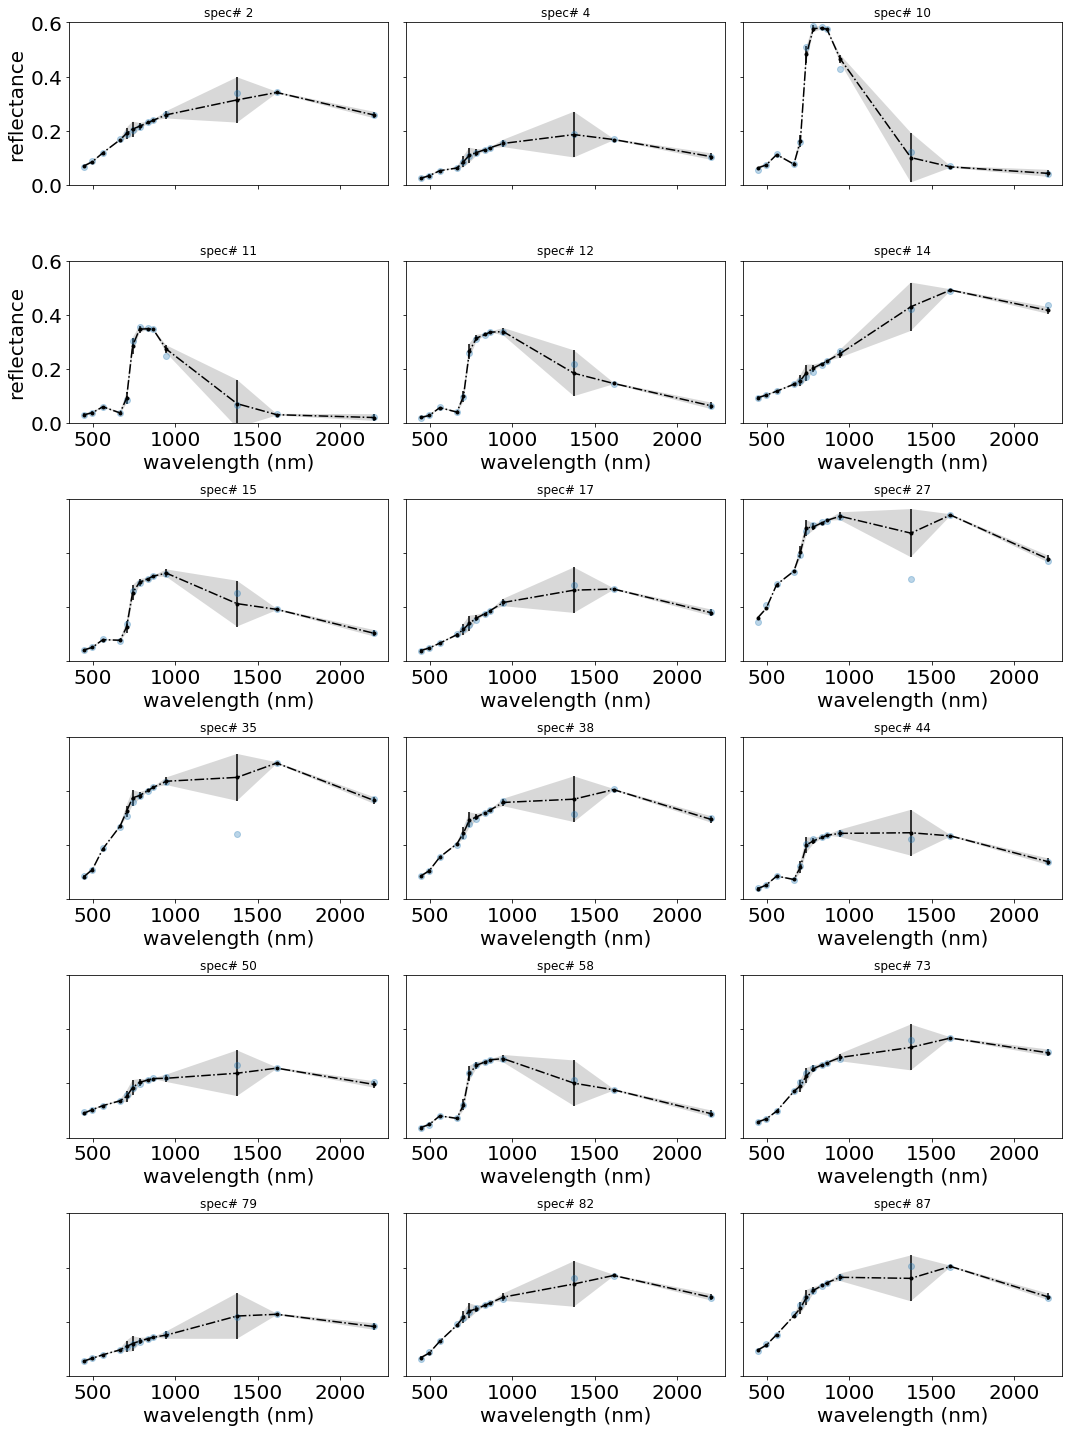

In [27]:
# define here sensorA and sensorB
# sensorA is the one to map to using band observations from sensorB
sensorB = 'terra'
sensorA = 'sentinel2'

# for 27 randomly selected spectra from the DLR database...
nrows = 6 # for image display
ncols = 3 # for image display
fig = plt.figure( figsize = (15, 20))
num_subplots = nrows * ncols

for i, spectrum_number in enumerate(test_idxs[:num_subplots]):
    cwlsA = integrated_spectra[sensorA]['cwls']
    m = len(cwlsA) # m number of bands in sensorA
    bandsA = range(m)
    spectrum = np.zeros((m, 4), dtype=float)
    for bandA in bandsA:
        cwlA = integrated_spectra[sensorA]['cwls'][bandA]
        y = integrated_spectra[sensorA]['integrefl'][:,bandA]

        integreflB = integrated_spectra[sensorB]['integrefl']
        bandsB = mappings[sensorA][bandA][sensorB]['bandsB']
        var_y_given_X = mappings[sensorA][bandA][sensorB]['var_y_given_X']
        beta_hat = mappings[sensorA][bandA][sensorB]['beta_hat']

        X_ = integreflB[:, bandsB]
        X = np.matrix( np.hstack(( np.ones( np.shape(X_)[0] ).reshape(( np.shape(X_)[0], 1)), X_ )) ) # create design matrix

        y_pred, var_y = evaluate(X, X, beta_hat, var_y_given_X)

        yp = float(y_pred[spectrum_number,0]) # y_pred is a column vector, we still index in full 2 dimensions...
        sigma = np.sqrt(float(var_y[spectrum_number]))
        t = 1.96
        y_lower = yp - (t * sigma)
        y_upper = yp + (t * sigma)

        spectrum[bandA, :] = y_lower, yp, y_upper, sigma
    
    # plot in order of centre wavelengths
    e = np.argsort(cwlsA)
    ax = fig.add_subplot(nrows, ncols, i+1)

    ax.set_ylim((0, 0.6))
    ax.locator_params(axis='y',nbins=4)
    if i+1 > 3:
        for tick in ax.xaxis.get_major_ticks():
            tick.label.set_fontsize(20)
        ax.set_xlabel("wavelength (nm)", fontsize=20)
    else:
        ax.set_xticklabels( () )

    
    if i+1 == 1 or i+1 == 4:
        for tick in ax.yaxis.get_major_ticks():
                tick.label.set_fontsize(20)
        ax.set_ylabel("reflectance", fontsize=20)
    else:
        ax.set_yticklabels(())
    
    plt.plot(cwlsA[e], integrated_spectra[sensorA]['integrefl'][spectrum_number, e], 'o', alpha=0.3)
    plt.errorbar(cwlsA[e], spectrum[e,1], yerr=1.96*spectrum[e,3], fmt='.', color='black')
    # in case you may want to interpolate between bands...
    plt.plot(cwlsA[e], spectrum[e,1], 'k-.')
    plt.fill_between(cwlsA[e], spectrum[e,0], spectrum[e,2], facecolor='grey', alpha = 0.3)
    plt.title('spec# %s' % spectrum_number)
    plt.locator_params(nbins=5)
    
plt.tight_layout()
plt.show() 



The illustrations show that with linear mapping functions derived from this DLR spectral database, we can derive suitable mappings and uncertainty quantification between any pairs of sensors. In the vase of Sentinel-2 (S2) to MODIS, we note the relatively large uncertainties in predicting MODIS bands 5 and 7 from S2 sampling, but that all uncertainties arising from this are really quite small.

In the case of MODIS to S2 mapping, it is (again) only in the SWIR that uncertainties become quite high.

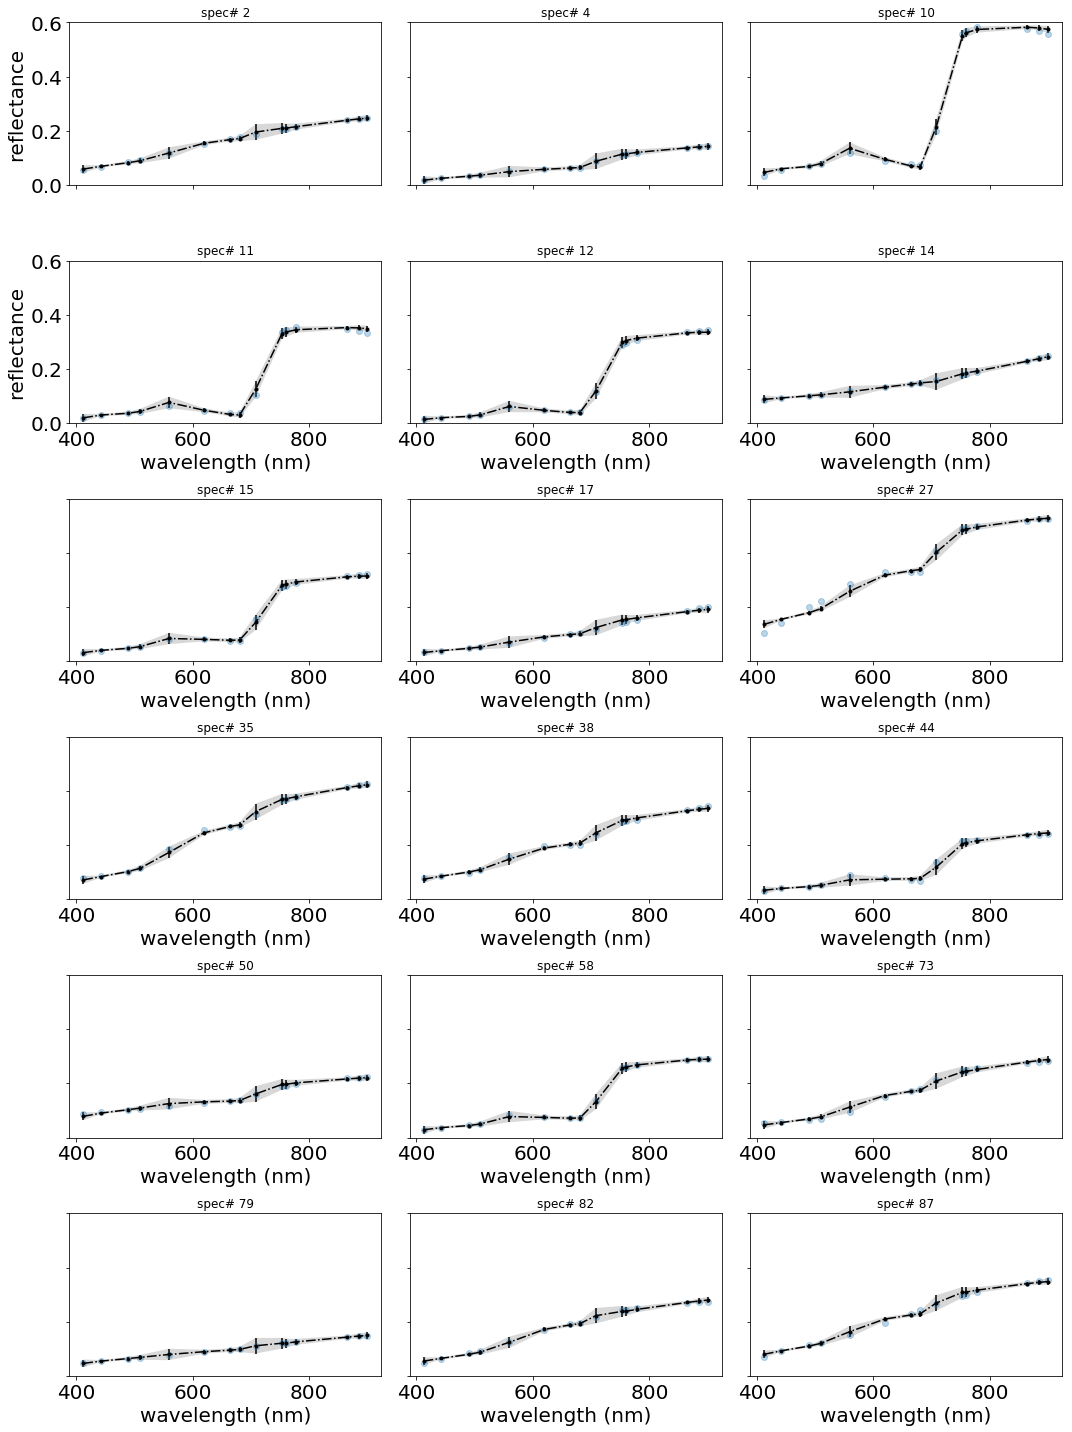

In [25]:
# define here sensorA and sensorB
# sensorA is the one to map to using band observations from sensorB
sensorB = 'vgt'
sensorA = 'meris'

# for 27 randomly selected spectra from the DLR database...
nrows = 6 # for image display
ncols = 3 # for image display
fig = plt.figure( figsize = (15, 20))
num_subplots = nrows * ncols

for i, spectrum_number in enumerate(test_idxs[:num_subplots]):
    cwlsA = integrated_spectra[sensorA]['cwls']
    m = len(cwlsA) # m number of bands in sensorA
    bandsA = range(m)
    spectrum = np.zeros((m, 4), dtype=float)
    for bandA in bandsA:
        cwlA = integrated_spectra[sensorA]['cwls'][bandA]
        y = integrated_spectra[sensorA]['integrefl'][:,bandA]

        integreflB = integrated_spectra[sensorB]['integrefl']
        bandsB = mappings[sensorA][bandA][sensorB]['bandsB']
        var_y_given_X = mappings[sensorA][bandA][sensorB]['var_y_given_X']
        beta_hat = mappings[sensorA][bandA][sensorB]['beta_hat']

        X_ = integreflB[:, bandsB]
        X = np.matrix( np.hstack(( np.ones( np.shape(X_)[0] ).reshape(( np.shape(X_)[0], 1)), X_ )) ) # create design matrix

        y_pred, var_y = evaluate(X, X, beta_hat, var_y_given_X)

        yp = float(y_pred[spectrum_number,0]) # y_pred is a column vector, we still index in full 2 dimensions...
        sigma = np.sqrt(float(var_y[spectrum_number]))
        t = 1.96
        y_lower = yp - (t * sigma)
        y_upper = yp + (t * sigma)

        spectrum[bandA, :] = y_lower, yp, y_upper, sigma
    
    # plot in order of centre wavelengths
    e = np.argsort(cwlsA)
    ax = fig.add_subplot(nrows, ncols, i+1)

    ax.set_ylim((0, 0.6))
    ax.locator_params(axis='y',nbins=4)
    if i+1 > 3:
        for tick in ax.xaxis.get_major_ticks():
            tick.label.set_fontsize(20)
        ax.set_xlabel("wavelength (nm)", fontsize=20)
    else:
        ax.set_xticklabels( () )

    
    if i+1 == 1 or i+1 == 4:
        for tick in ax.yaxis.get_major_ticks():
                tick.label.set_fontsize(20)
        ax.set_ylabel("reflectance", fontsize=20)
    else:
        ax.set_yticklabels(())
    
    plt.plot(cwlsA[e], integrated_spectra[sensorA]['integrefl'][spectrum_number, e], 'o', alpha=0.3)
    plt.errorbar(cwlsA[e], spectrum[e,1], yerr=1.96*spectrum[e,3], fmt='.', color='black')
    # in case you may want to interpolate between bands...
    plt.plot(cwlsA[e], spectrum[e,1], 'k-.')
    plt.fill_between(cwlsA[e], spectrum[e,0], spectrum[e,2], facecolor='grey', alpha = 0.3)
    plt.title('spec# %s' % spectrum_number)
    plt.locator_params(nbins=5)
    
plt.tight_layout()
plt.show() 




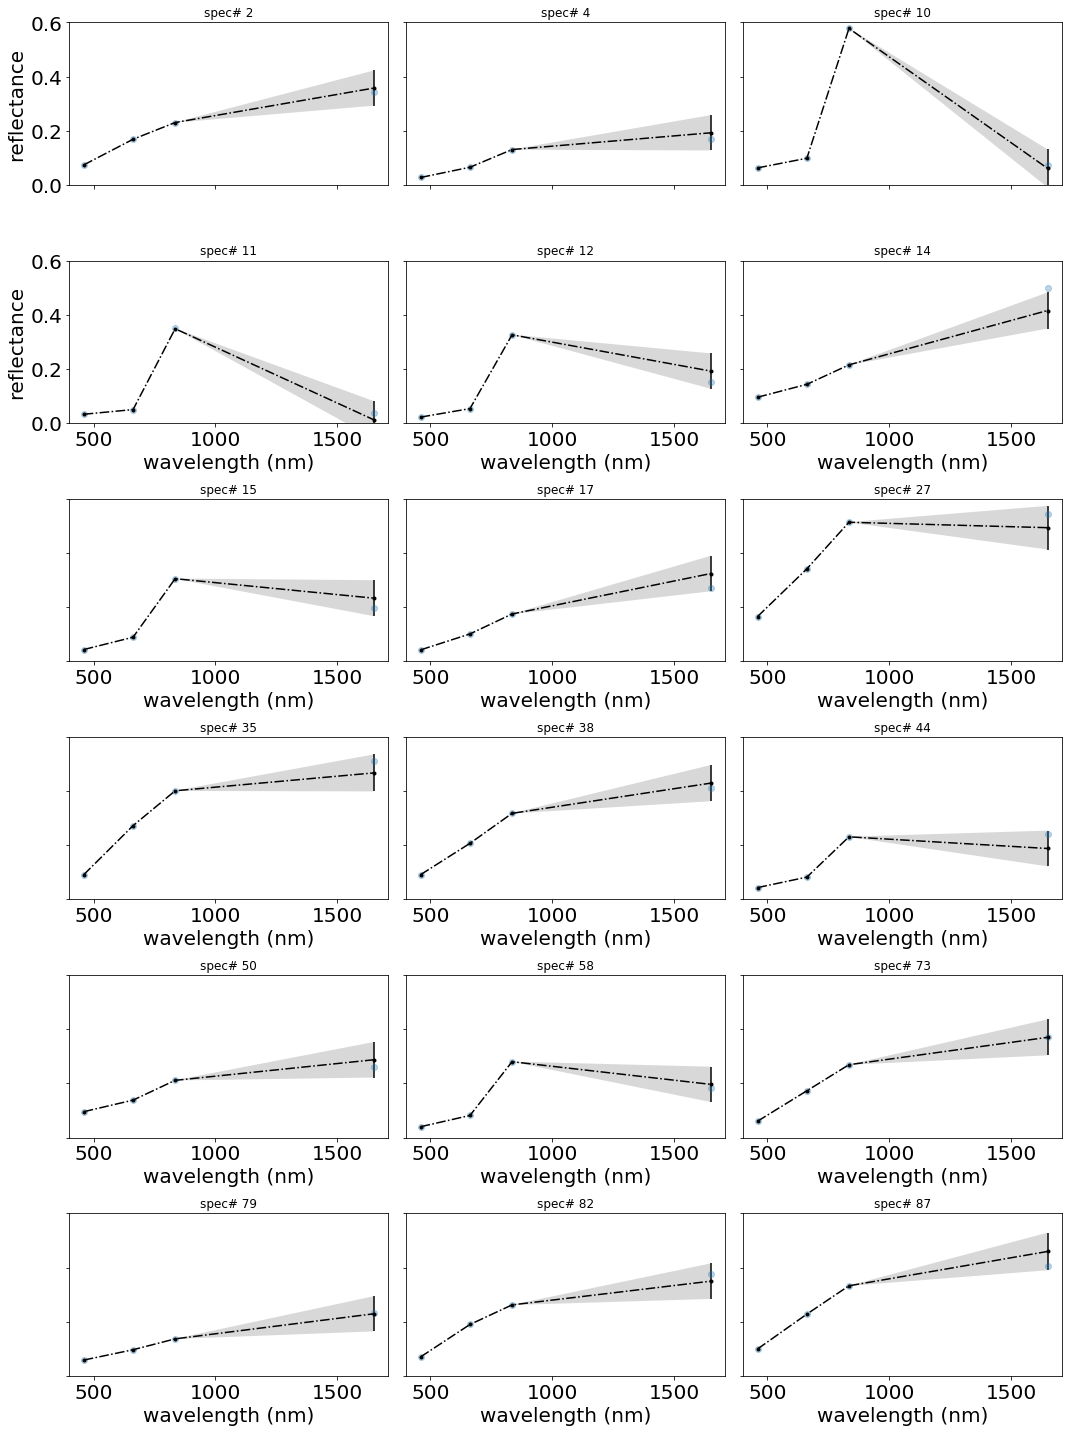

In [26]:
# define here sensorA and sensorB
# sensorA is the one to map to using band observations from sensorB
sensorA = 'vgt'
sensorB = 'meris'

# for 27 randomly selected spectra from the DLR database...
nrows = 6 # for image display
ncols = 3 # for image display
fig = plt.figure( figsize = (15, 20))
num_subplots = nrows * ncols

for i, spectrum_number in enumerate(test_idxs[:num_subplots]):
    cwlsA = integrated_spectra[sensorA]['cwls']
    m = len(cwlsA) # m number of bands in sensorA
    bandsA = range(m)
    spectrum = np.zeros((m, 4), dtype=float)
    for bandA in bandsA:
        cwlA = integrated_spectra[sensorA]['cwls'][bandA]
        y = integrated_spectra[sensorA]['integrefl'][:,bandA]

        integreflB = integrated_spectra[sensorB]['integrefl']
        bandsB = mappings[sensorA][bandA][sensorB]['bandsB']
        var_y_given_X = mappings[sensorA][bandA][sensorB]['var_y_given_X']
        beta_hat = mappings[sensorA][bandA][sensorB]['beta_hat']

        X_ = integreflB[:, bandsB]
        X = np.matrix( np.hstack(( np.ones( np.shape(X_)[0] ).reshape(( np.shape(X_)[0], 1)), X_ )) ) # create design matrix

        y_pred, var_y = evaluate(X, X, beta_hat, var_y_given_X)

        yp = float(y_pred[spectrum_number,0]) # y_pred is a column vector, we still index in full 2 dimensions...
        sigma = np.sqrt(float(var_y[spectrum_number]))
        t = 1.96
        y_lower = yp - (t * sigma)
        y_upper = yp + (t * sigma)

        spectrum[bandA, :] = y_lower, yp, y_upper, sigma
    
    # plot in order of centre wavelengths
    e = np.argsort(cwlsA)
    ax = fig.add_subplot(nrows, ncols, i+1)

    ax.set_ylim((0, 0.6))
    ax.locator_params(axis='y',nbins=4)
    if i+1 > 3:
        for tick in ax.xaxis.get_major_ticks():
            tick.label.set_fontsize(20)
        ax.set_xlabel("wavelength (nm)", fontsize=20)
    else:
        ax.set_xticklabels( () )

    
    if i+1 == 1 or i+1 == 4:
        for tick in ax.yaxis.get_major_ticks():
                tick.label.set_fontsize(20)
        ax.set_ylabel("reflectance", fontsize=20)
    else:
        ax.set_yticklabels(())
    
    plt.plot(cwlsA[e], integrated_spectra[sensorA]['integrefl'][spectrum_number, e], 'o', alpha=0.3)
    plt.errorbar(cwlsA[e], spectrum[e,1], yerr=1.96*spectrum[e,3], fmt='.', color='black')
    # in case you may want to interpolate between bands...
    plt.plot(cwlsA[e], spectrum[e,1], 'k-.')
    plt.fill_between(cwlsA[e], spectrum[e,0], spectrum[e,2], facecolor='grey', alpha = 0.3)
    plt.title('spec# %s' % spectrum_number)
    plt.locator_params(nbins=5)
    
plt.tight_layout()
plt.show() 





Similarly, looking at the mappings from VGT to MERIS, we see that the uncertainty inb mapping from VGT to MERIS is quite small, but when mapping from MERIS to VGT, the uncertainty in the SWIR becomes large. This is because MERIS has no spectral sampling in this region, and the mapping is enavbled simply by correlations in the data.

This is very positive for the approach developed here, as it demonstrates that we can achive sensible spectral mappings between datasets from sensors with different spectral sampling. Where the wavebands of the two sensors are close, we tend to get low uncertainties. In extrapolation (as in the MERIS to VGT case) the uncertainty can be quite high, but that is appropriate: pseudo-observations at such wavelengths will then have low weight in constraining albedo.